In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import json
import requests
from bs4 import BeautifulSoup

plt.rcParams["font.family"] = "MonaspiceXe NFM"

In [2]:
"""
Scraping. Be careful - takes time!
"""

for i in range(1, 510):
    # URL of the website you want to scrape (replace with the actual URL)
    url = f"https://www.intercity.pl/pl/site/dla-pasazera/obsluga-klientow/odbior-zagubionego-bagazu.html?page={i}"

    headers =  {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36' -s",
    }

    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the table by its class name (replace the class name if different)
        table = soup.find('div', class_='table-responsive').find('table', class_='table')

        # Extract headers
        headers = [header.text for header in table.find('thead').find_all('th')]

        # Extract table rows
        rows = table.find('tbody').find_all('tr')
        table_data = []

        # Loop through rows and extract each cell's text
        for row in rows:
            cells = row.find_all('td')
            row_data = [cell.text.strip() for cell in cells]  # Strip any extra whitespace
            table_data.append(row_data)

        if i == 1:
            # Create a DataFrame from the extracted data
            df = pd.DataFrame(table_data, columns=headers)
        else:
            df = pd.concat([df, pd.DataFrame(table_data, columns=headers)], axis=0, ignore_index=True)
    else:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

df.to_csv("lost_and_found.csv")

KeyboardInterrupt: 

In [33]:
# Read the data
df = pd.read_csv("lost_and_found.csv")
df["Dzień Znalezienia"] = pd.to_datetime(df["Dzień Znalezienia"], format="%Y-%m-%d")
df["Dzień tygodnia"] = df["Dzień Znalezienia"].dt.weekday

df.head()

,Unnamed: 0,Dzień Znalezienia,Numer Pociągu,Relacja Pociągu,Stacja Znalezienia,Rodzaj Rzeczy,Dzień tygodnia
0,0,2024-10-13,5620,Ełk - Wrocław Gł.,WROCŁAW GŁ.,WALIZKA / PLECAK,6
1,1,2024-10-13,1115,Warszawa Wschodnia-Terespol,Terespol,DOKUMENT/Y,6
2,2,2024-10-13,5460,Olsztyn Gł. - Wisła Uzdr.,KOLUSZKI,SPRZĘT TURYSTYCZNY,6
3,3,2024-10-13,61106,WROCŁAW GŁ - BIAŁYSTOK,BIAŁYSTOK,SPRZĘT ELEKTRONICZNY,6
4,4,2024-10-13,1304,Warszawa Wsch. - Kraków Gł.,KRAKÓW GŁ.,WALIZKA / PLECAK,6


In [34]:
corrections = json.load(open("./corrections.txt"))

df["Stacja Znalezienia"] = df["Stacja Znalezienia"].str.title()
df["Stacja Znalezienia"] = df["Stacja Znalezienia"].replace(corrections)

df["Rodzaj Rzeczy"] = df["Rodzaj Rzeczy"].str.title()

df["Relacja Pociągu"] = df["Relacja Pociągu"].str.title()

# sorted(df[3].dropna().astype(str).unique())

,Unnamed: 0,Dzień Znalezienia,Numer Pociągu,Relacja Pociągu,Stacja Znalezienia,Rodzaj Rzeczy,Dzień tygodnia
0,0,2024-10-13,5620,Ełk - Wrocław Gł.,Wrocław Główny,Walizka / Plecak,6
1,1,2024-10-13,1115,Warszawa Wschodnia-Terespol,Terespol,Dokument/Y,6
2,2,2024-10-13,5460,Olsztyn Gł. - Wisła Uzdr.,Koluszki,Sprzęt Turystyczny,6
3,3,2024-10-13,61106,Wrocław Gł - Białystok,Białystok,Sprzęt Elektroniczny,6
4,4,2024-10-13,1304,Warszawa Wsch. - Kraków Gł.,Kraków Główny,Walizka / Plecak,6
...,...,...,...,...,...,...,...
5085,5085,2024-02-06,6302,Wrocław Gł. - Przemyśl Gł.,Bochnia,Telefon Komórkowy,1
5086,5086,2024-02-05,3800,Kraków Gł. - Kołobrzeg,Kołobrzeg,Ładowarka Do Telefonu,0
5087,5087,2024-02-05,38100,Lublin Główny-Gorzów Wielkopolski,Lublin,Papierowa Torba Z Pojemnikami Za Żywność,0
5088,5088,2024-02-04,1201,Łódź Fabryczna -Lublin,Lublin,Legitymacja Studencka,6


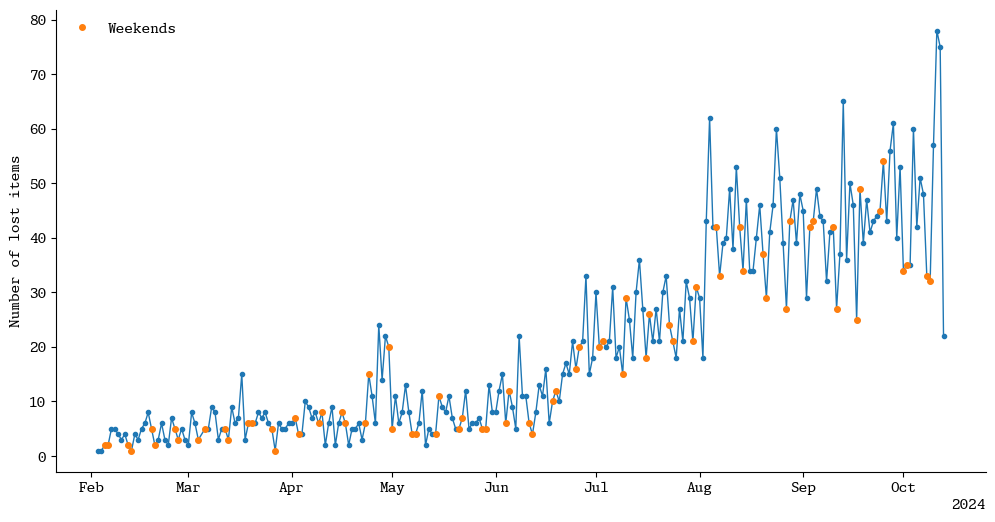

In [35]:
# Items lost in time, with weekends highlighted

counts = df.groupby("Dzień Znalezienia").count()["Rodzaj Rzeczy"]

date = counts.index
val = counts.values

fig, ax = plt.subplots(1, figsize=(12,6))

ax.plot(date, val, lw=1, marker=".")
ax.plot(date[2::7], val[2::7], lw=0, marker=".", c="tab:orange", ms=8, label="Weekends")
ax.plot(date[3::7], val[3::7], lw=0, marker=".", c="tab:orange", ms=8)

ax.set_ylabel("Number of lost items")

ax.spines[['right', 'top']].set_visible(False)

ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.legend(frameon=False)

plt.savefig("./img/number_of_lost_items_weekends.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

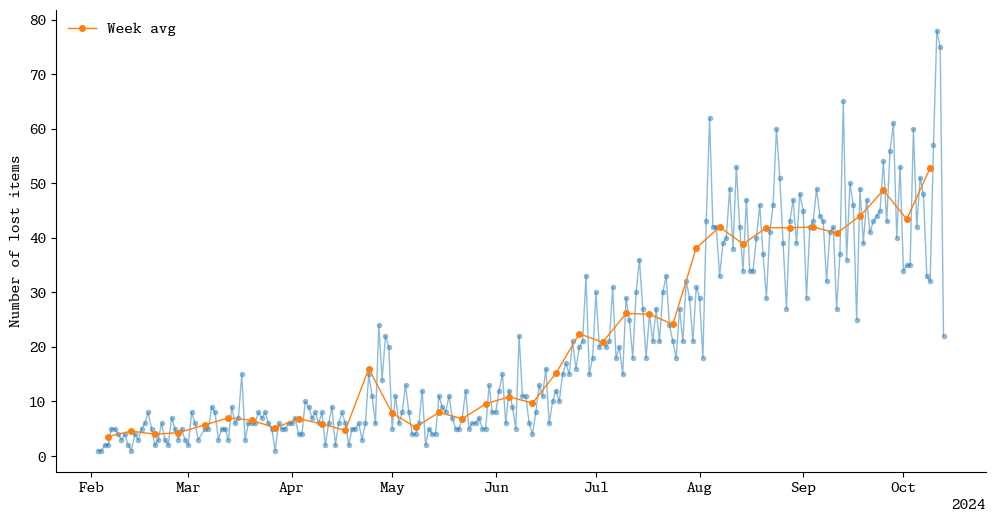

In [36]:
# Items lost in time, with weekly average 

counts = df.groupby("Dzień Znalezienia").count()["Rodzaj Rzeczy"]

date = counts.index
val = counts.values

# get the weekly average
weeks = []

for i in range(3, len(val), 7):
    weeks.append(val[i:i+7].mean())

# plot
fig, ax = plt.subplots(1, figsize=(12,6))

ax.plot(date, val, lw=1, marker=".", alpha=0.5, markeredgecolor='none', ms=8)
ax.plot(date[3::7], weeks, label="Week avg", lw=1, marker=".", c="tab:orange", ms=8)

ax.set_ylabel("Number of lost items")

ax.spines[['right', 'top']].set_visible(False)

ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.legend(frameon=False)

plt.savefig("./img/number_of_lost_items.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

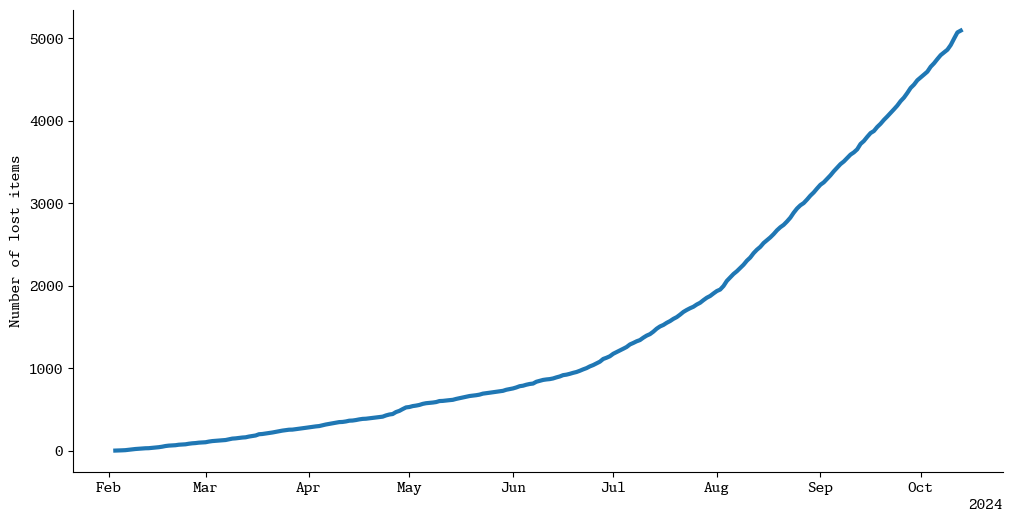

In [37]:
# Cummulative 

counts = df.groupby("Dzień Znalezienia").count()["Rodzaj Rzeczy"]

date = counts.index
val = counts.values

# plot
fig, ax = plt.subplots(1, figsize=(12,6))

ax.plot(date, np.cumsum(val), lw=3, marker="", alpha=1, markeredgecolor='none', ms=8)
ax.set_ylabel("Number of lost items")

ax.spines[['right', 'top']].set_visible(False)

ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

plt.savefig("./img/number_of_lost_items_cum.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

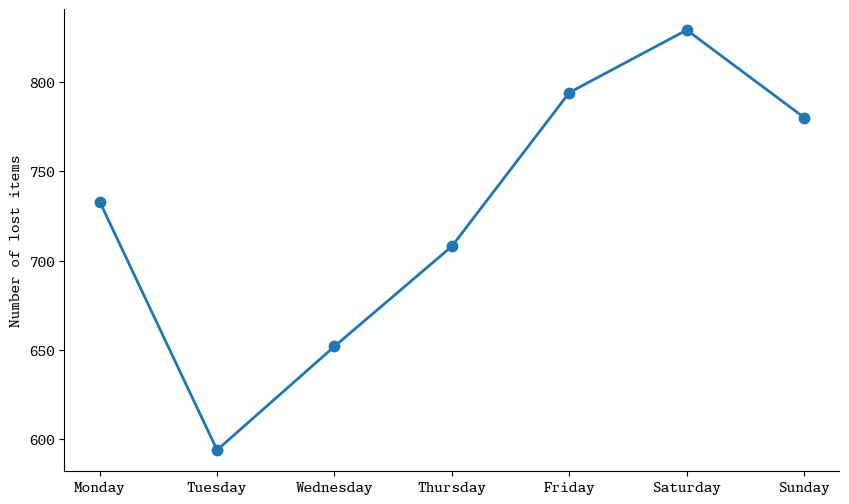

In [38]:
# Weekly distribution

dayofweek = df.groupby("Dzień tygodnia").count()["Rodzaj Rzeczy"]

dow = dayofweek.index
dow_val = dayofweek.values

dow = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig, ax = plt.subplots(1, figsize=(10,6))

ax.plot(dow, dow_val, lw=2, marker=".", ms=15)

ax.set_ylabel("Number of lost items")

ax.spines[['right', 'top']].set_visible(False)

plt.savefig("./img/day_of_week.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [39]:
def fill_with_zero(df):
    """
    Fill missing dates with zero
    """
    idx = pd.date_range('02-01-2024', '10-04-2024')

    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=0)

    return df

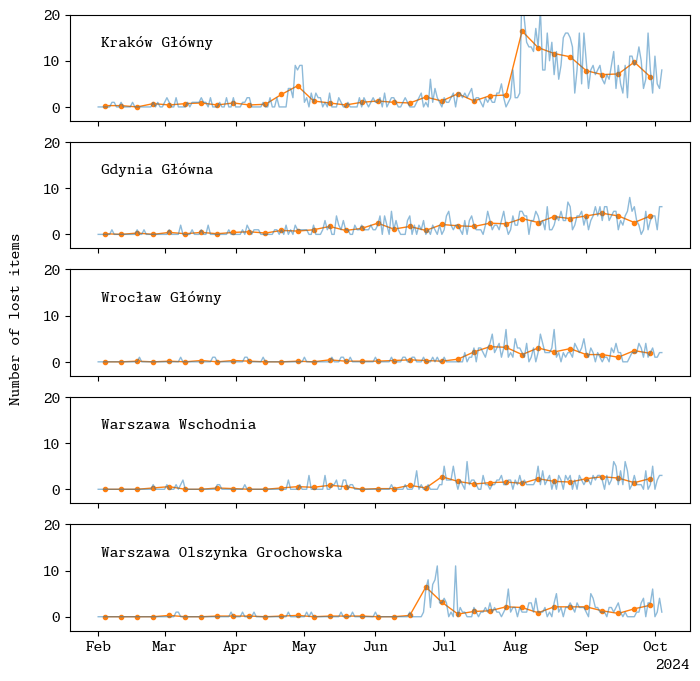

In [40]:
# Top N cities with items lost and the distribution in time

N = 5

fig, axes = plt.subplots(N,1, sharex=True, figsize=(8,8))

for i in range(N):
    city = df["Stacja Znalezienia"].value_counts().index[i]
    
    dane = df[df["Stacja Znalezienia"]==city]["Dzień Znalezienia"].value_counts()

    dane = fill_with_zero(dane)
    
    idx = dane.index.argsort()
    
    date = dane.index[idx]
    val = dane.values[idx]

    # get the weekly average
    weeks = []
    
    for j in range(3, len(val), 7):
        weeks.append(val[j:j+7].mean())

    axes[i].plot(date[3::7], weeks, lw=1, marker=".", c="tab:orange", ms=6)
        
    axes[i].plot(date, val, lw=1, marker="", alpha=0.5)
    
    axes[i].set_ylim(-3, 20)
    
    axes[i].annotate(city, xy=(0.05,0.7), xycoords='axes fraction')
    
    axes[i].xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    
fig.text(0.05, 0.5, 'Number of lost items', va='center', rotation='vertical')

plt.savefig("./img/cities.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

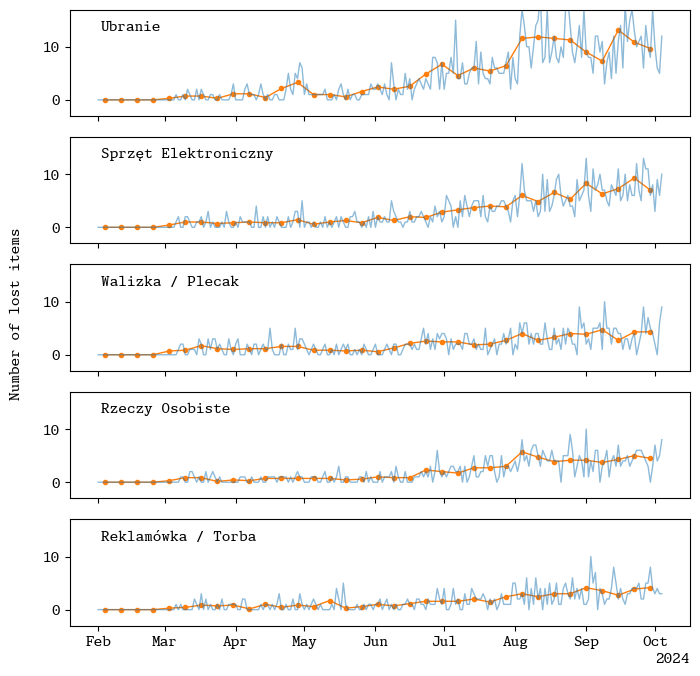

In [41]:
# Top N items lost and the distribution in time

N = 5

fig, axes = plt.subplots(N,1, sharex=True, figsize=(8,8))

for i in range(N):
    item = df["Rodzaj Rzeczy"].value_counts().index[i]
    
    dane = df[df["Rodzaj Rzeczy"]==item]["Dzień Znalezienia"].value_counts()
    
    dane = fill_with_zero(dane)
    
    idx = dane.index.argsort()
    
    date = dane.index[idx]
    val = dane.values[idx]

    # get the weekly average
    weeks = []

    for j in range(3, len(val), 7):
        weeks.append(val[j:j+7].mean())

    axes[i].plot(date[3::7], weeks, lw=1, marker=".", c="tab:orange", ms=6)
        
    axes[i].plot(date, val, lw=1, marker="", alpha=0.5)
    
    axes[i].set_ylim(-3, 17)
    
    axes[i].annotate(item, xy=(0.05,0.9), xycoords='axes fraction', ha='left', va='top')

    axes[i].xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

fig.text(0.05, 0.5, 'Number of lost items', va='center', rotation='vertical')

plt.savefig("./img/items.svg", bbox_inches='tight', transparent=True, pad_inches=0)

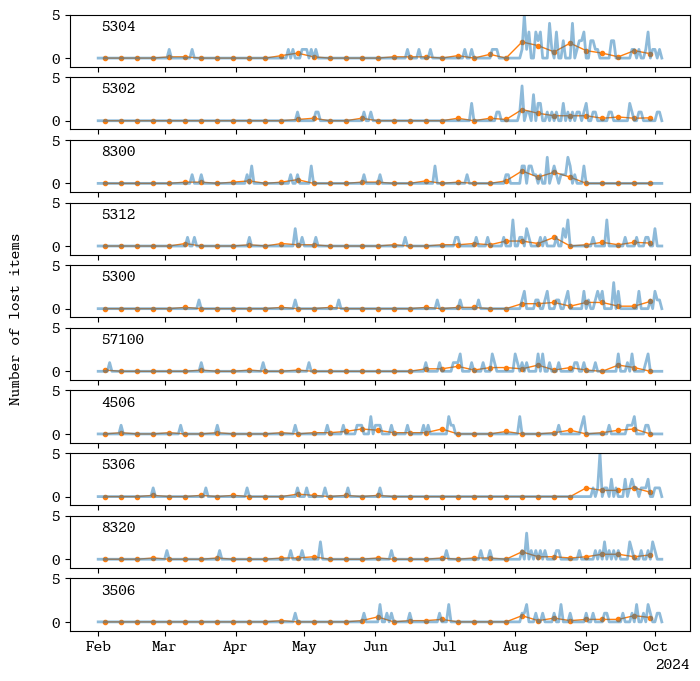

In [45]:
# Top N routes with lost items and the distribution in time

N = 10

fig, axes = plt.subplots(N,1, sharex=True, figsize=(8,8))

for i in range(N):
    route = df["Numer Pociągu"].value_counts().index[i]
    
    dane = df[df["Numer Pociągu"]==route]["Dzień Znalezienia"].value_counts()

    dane = fill_with_zero(dane)
    
    idx = dane.index.argsort()
    
    date = dane.index[idx]
    val = dane.values[idx]

    # get the weekly average
    weeks = []

    for j in range(3, len(val), 7):
        weeks.append(val[j:j+7].mean())

    axes[i].plot(date[3::7], weeks, lw=1, marker=".", c="tab:orange", ms=6)

        
    axes[i].plot(date, val, lw=2, marker="", alpha=0.5)
    
    axes[i].set_ylim(-1, 5)
    
    axes[i].annotate(route, xy=(0.05,0.7), xycoords='axes fraction')
    
    axes[i].xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    # axes[i].axvline(pd.to_datetime('2024-6-28'), lw=1, c="black", ls="--", alpha=0.5)

fig.text(0.05, 0.5, 'Number of lost items', va='center', rotation='vertical')

plt.savefig("./img/routes.svg", bbox_inches='tight', transparent=True, pad_inches=0)

In [17]:
# Look for correlation between items and cities

N = 20
M = 20

cities = df["Stacja Znalezienia"].value_counts().index[:M].values
items = df["Rodzaj Rzeczy"].value_counts().index[:N].values

corr = []

for i in range(N):
    tmp = []
    for j in range(M):
        tmp.append(df.loc[df["Rodzaj Rzeczy"].eq(items[i]) & df["Stacja Znalezienia"].eq(cities[j])]["Dzień Znalezienia"].count())

    corr.append(tmp)

corr = np.array(corr)

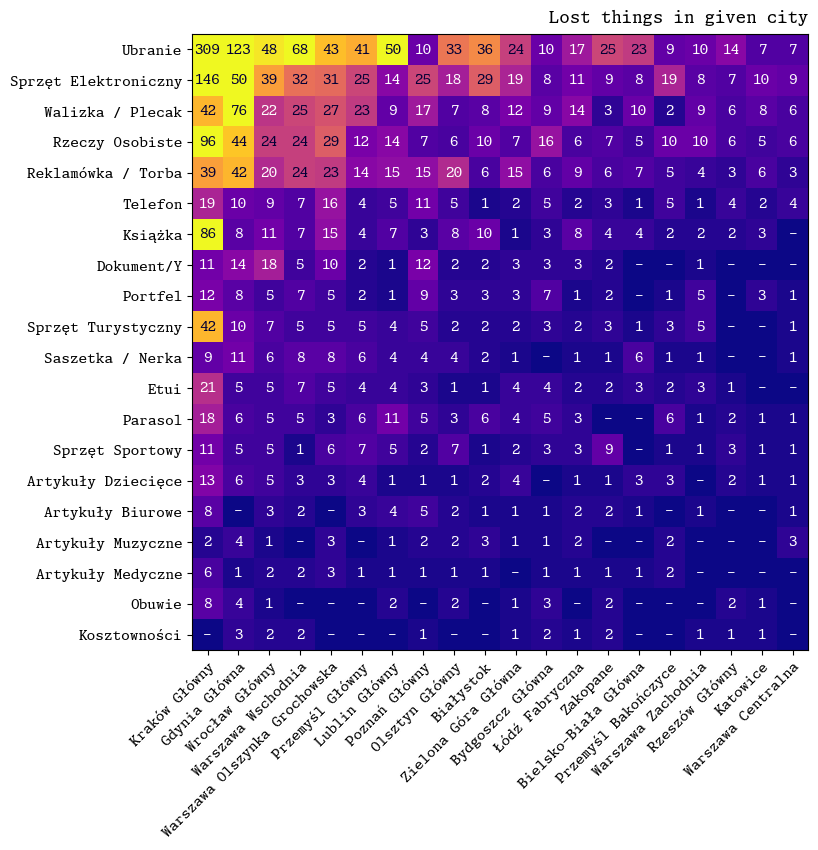

In [19]:
# Total number of items lost in biggest cities

fig, ax = plt.subplots(figsize=(8,8))

percent = (corr.transpose()/df["Rodzaj Rzeczy"].value_counts().values[:N]).transpose()

ax.imshow(corr, cmap="plasma", vmax=50)
# ax.imshow(corr, vmax=50)

ax.set_xticks(np.arange(M), labels=cities)
ax.set_yticks(np.arange(N), labels=items)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(N):
    for j in range(M):
        if corr[i, j] < 23 and corr[i, j] >= 1:
            text = ax.text(j, i, f"{corr[i, j]:.0f}",
                           ha="center", va="center", color="w", size=10)
        elif corr[i, j] < 1:
            text = ax.text(j, i, f"-",
               ha="center", va="center", color="w", size=10)
        else:
            text = ax.text(j, i, f"{corr[i, j]:.0f}",
                           ha="center", va="center", color="xkcd:midnight blue", size=10)

ax.set_title("Lost things in given city", loc="right", va="bottom")

plt.savefig("./img/lost_things_in_city.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

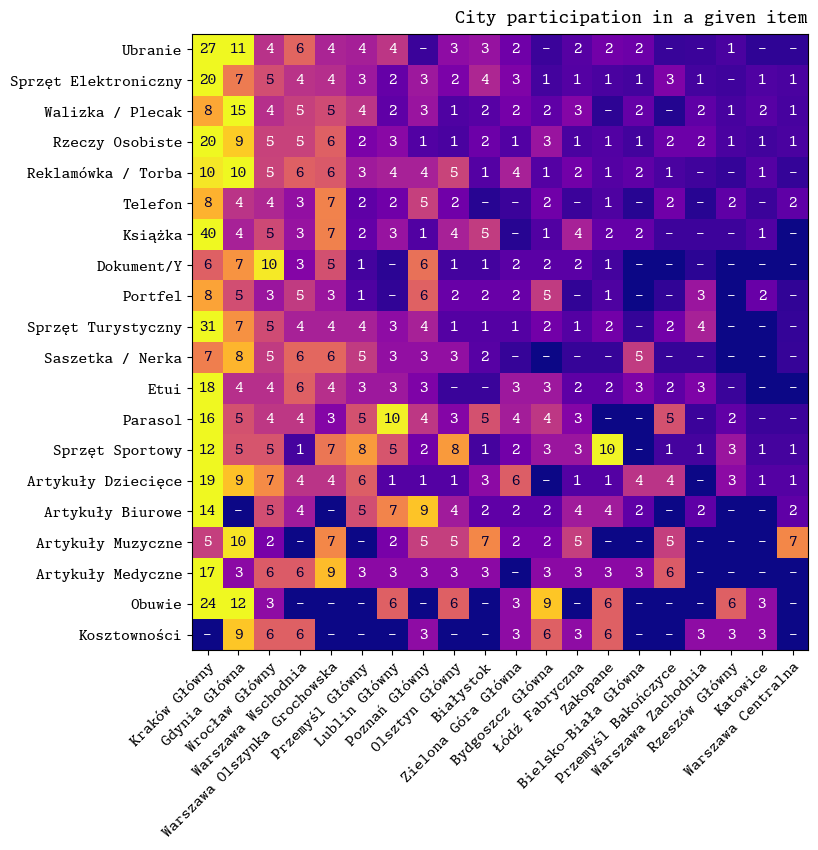

In [21]:
# City participation in a given item [percent]

fig, ax = plt.subplots(figsize=(8,8))

percent = (corr.transpose()/df["Rodzaj Rzeczy"].value_counts().values[:N]).transpose()

ax.imshow(percent, cmap="plasma", vmax=0.1)
# ax.imshow(corr, vmax=50)

ax.set_xticks(np.arange(M), labels=cities)
ax.set_yticks(np.arange(N), labels=items)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(N):
    for j in range(M):
        if percent[i, j] < 0.01:
            text = ax.text(j, i, f"-",
               ha="center", va="center", color="w", size=10)
        elif percent[i, j] <= 0.05:
            text = ax.text(j, i, f"{percent[i, j]*100:.0f}",
                           ha="center", va="center", color="w", size=10)
        else:
            text = ax.text(j, i, f"{percent[i, j]*100:.0f}",
                           ha="center", va="center", color="xkcd:midnight blue", size=10)

ax.set_title("City participation in a given item", loc="right", va="bottom")

plt.savefig("./img/city_participation.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

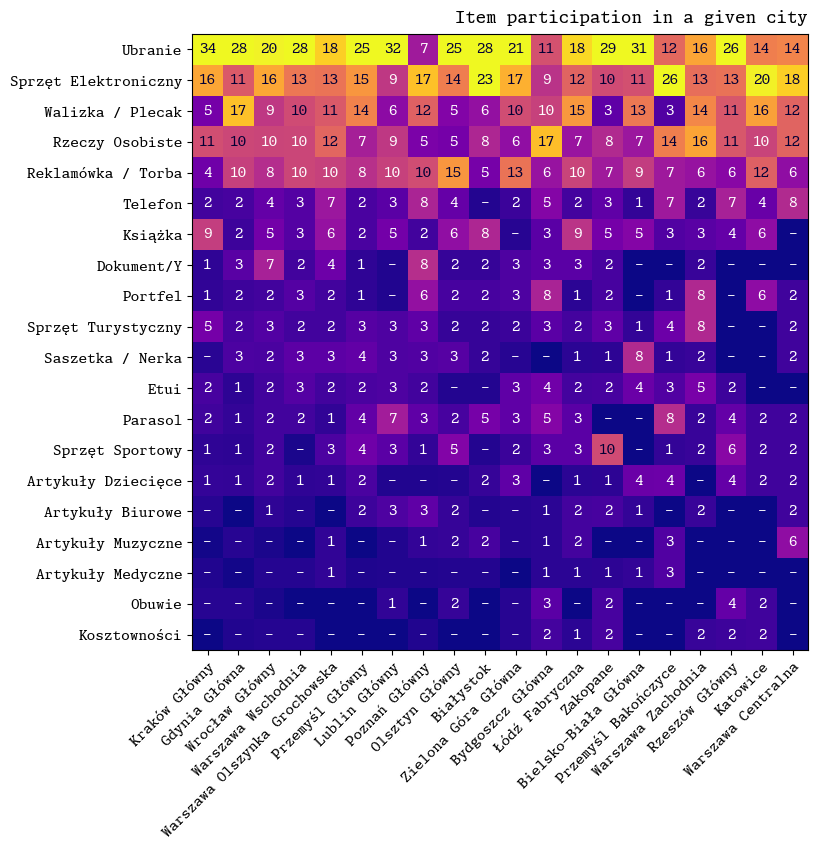

In [22]:
# Item participation in a given city [percent

fig, ax = plt.subplots(figsize=(8,8))

percent = corr/df["Stacja Znalezienia"].value_counts().values[:N]

ax.imshow(percent, cmap="plasma", vmax=0.2)
# ax.imshow(corr, vmax=50)

ax.set_xticks(np.arange(M), labels=cities)
ax.set_yticks(np.arange(N), labels=items)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(N):
    for j in range(M):
        if percent[i, j] < 0.01:
            text = ax.text(j, i, f"-",
               ha="center", va="center", color="w", size=10)
        elif percent[i, j] <= 0.1:
            text = ax.text(j, i, f"{percent[i, j]*100:.0f}",
                           ha="center", va="center", color="w", size=10)
        else:
            text = ax.text(j, i, f"{percent[i, j]*100:.0f}",
                           ha="center", va="center", color="xkcd:midnight blue", size=10)

ax.set_title("Item participation in a given city", loc="right", va="bottom")

plt.savefig("./img/item_participation.svg", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()